# SETUP

In [1]:
!pip install catboost noisereduce kymatio optuna

<h1>ALL Library</h1>

In [3]:
# ==========================
# BASIC & SYSTEM
# ==========================
import os
import io
import glob
import ast
import csv
import shutil
import random
import warnings
from pathlib import Path
from collections import Counter, defaultdict
from warnings import filterwarnings

# ==========================
# DATA & NUMPY / PANDAS
# ==========================
import numpy as np
import pandas as pd

# ==========================
# VISUALIZATION
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# AUDIO PROCESSING
# ==========================
import librosa
import librosa.display as lplt
from IPython.display import Audio
from scipy.io import wavfile
import noisereduce as nr

# Torchaudio transforms
from torchaudio.transforms import (
    MelSpectrogram,
    AmplitudeToDB,
    Resample,
    Vol,
    MFCC,
    SpectralCentroid,
    Spectrogram
)
from sklearn.model_selection import train_test_split
# Kymatio
from kymatio import Scattering1D
from kymatio.torch import Scattering1D
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold
)
from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder
)
from sklearn.metrics import (
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import (
    compute_class_weight,
    compute_sample_weight
)
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# ==========================
# BOOSTING MODELS
# ==========================
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# ==========================
# PYTORCH
# ==========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.models as models
import torchaudio
# ==========================
# TENSORFLOW / KERAS
# ==========================
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import (
    Dense, Dropout, BatchNormalization, Input,
    Conv2D, Flatten, MaxPool2D, AveragePooling2D,
    GlobalAveragePooling2D, LSTM, GRU, Bidirectional
)
from keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

# ==========================
# UTILITIES
# ==========================
from tqdm.auto import tqdm
import scipy.ndimage as ndi
from keras.metrics import F1Score, Precision, Recall
from keras.callbacks import Callback
import math
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
softmax = torch.nn.Softmax(dim=1)

import optuna

# ==========================
# SETTINGS
# ==========================
filterwarnings("ignore")
np.random.seed(42)
pd.set_option('display.max_columns', None)


In [4]:
SEED = 1337
rng = np.random.RandomState(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
tf.random.set_seed(SEED)

In [5]:
train=pd.read_csv("train - train .csv")
train.head()
test=pd.read_csv("test - test.csv")
test.head()

train_path = "decoded_audio-20251111T045524Z-1-001/decoded_audio/train"
train['audio'] = train['audio'].apply(lambda x: os.path.join(train_path, x + '.wav'))
test_path = "decoded_audio-20251111T045524Z-1-001/decoded_audio/test"
test['audio'] = test['audio'].apply(lambda x: os.path.join(test_path,x + '.wav'))

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LABEL = 'species'

In [7]:
outdir = "audio_files"
os.makedirs(outdir, exist_ok=True)

for _, row in train.iterrows():
    species_dir = os.path.join(outdir, row["species"])
    os.makedirs(species_dir, exist_ok=True)
    src = row["audio"]                       
    dst = os.path.join(species_dir, os.path.basename(src))
    shutil.copy2(src, dst)                   

<h1>Sample Rate to 47600</h1>

In [9]:
# outdir = Path("audio_files")
# SR = 47600
# audio_store = {}
# wav_paths = [p for p in outdir.rglob("*.wav")]

# for path in wav_paths:
#     name_class = path.parent.name
#     y, sr = librosa.load(path, sr=None)
#     y = librosa.resample(y, orig_sr=sr, target_sr=SR)
#     key = str(path.relative_to(outdir))  
#     audio_store[key] = {'signal': y, 'sr': SR, 'species': name_class}

# audio_df = pd.DataFrame.from_dict(audio_store, orient='index')
# audio_df.reset_index(inplace=True)
# audio_df


,index,signal,sr,species
0,Spinner_Dolphin/train-00000-of-00003_0.wav,"[0.00910588, 0.015781939, 0.007067535, -0.0083...",47600,Spinner_Dolphin
1,Spinner_Dolphin/train-00000-of-00003_9.wav,"[-0.010044245, -0.0042164586, 0.016246572, -0....",47600,Spinner_Dolphin
2,Spinner_Dolphin/train-00000-of-00003_33.wav,"[-0.0068150368, -0.016458714, -0.006996421, -0...",47600,Spinner_Dolphin
3,Spinner_Dolphin/train-00000-of-00003_46.wav,"[-0.004888163, -0.015361304, -0.020827156, -0....",47600,Spinner_Dolphin
4,Spinner_Dolphin/train-00000-of-00003_71.wav,"[0.008240316, 0.009132383, 0.012484275, 0.0281...",47600,Spinner_Dolphin
...,...,...,...,...
1352,Leopard_Seal/train-00000-of-00003_403.wav,"[-0.002156999, -0.002008427, -0.0013732668, -0...",47600,Leopard_Seal
1353,Leopard_Seal/train-00001-of-00003_110.wav,"[0.038946036, 0.045467038, 0.04854716, 0.04876...",47600,Leopard_Seal
1354,Leopard_Seal/train-00002-of-00003_93.wav,"[0.001106685, 0.0014083944, 0.0016736165, 0.00...",47600,Leopard_Seal
1355,Leopard_Seal/train-00002-of-00003_188.wav,"[-0.0065745395, -0.0073023792, -0.0072597954, ...",47600,Leopard_Seal


In [8]:
from pathlib import Path
import librosa
import numpy as np
import pandas as pd
import noisereduce as nr

outdir = Path("audio_files")
FINAL_SR = 47600

def apply_preemphasis(y):
    return librosa.effects.preemphasis(y, coef=0.97)

audio_store = {}
wav_paths = [p for p in outdir.rglob("*.wav")]

for path in wav_paths:
    name_class = path.parent.name
    y, sr = librosa.load(path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=FINAL_SR)
    y = apply_preemphasis(y)
    y = nr.reduce_noise(y=y.astype(np.float32), sr=FINAL_SR)

    key = str(path.relative_to(outdir))
    audio_store[key] = {
        'signal': y.astype(np.float32),
        'sr': FINAL_SR,
        'species': name_class,
        'orig_sr': sr,
        'category': 'uniform'
    }

audio_df = pd.DataFrame.from_dict(audio_store, orient='index')
audio_df.reset_index(inplace=True)


In [9]:
new_path = "audio_files"
audio_df['index'] = audio_df['index'].apply(lambda x: os.path.join(new_path, x ))

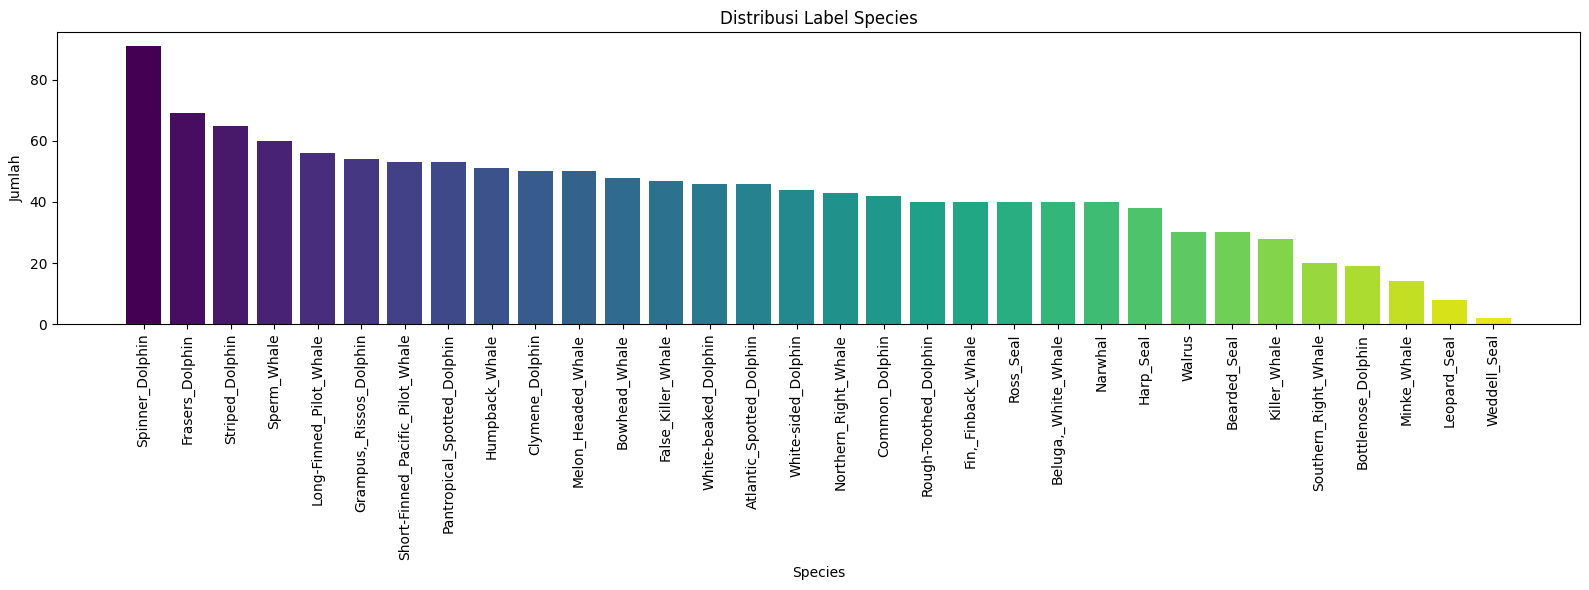

In [10]:
import matplotlib.pyplot as plt

# sort berdasarkan jumlah (descending)
species_counts = audio_df['species'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(16, 6))

# gradasi warna berdasarkan urutan
cmap = plt.cm.viridis
colors = cmap([i / len(species_counts) for i in range(len(species_counts))])

plt.bar(species_counts.index, species_counts.values, color=colors)
plt.xticks(rotation=90)
plt.title("Distribusi Label Species")
plt.xlabel("Species")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()


# Image Pipeline

<h2>Preprocessing And Denoising</h2>

In [9]:
import torchaudio
data_full_list = []
srate_full_list = []
y_labs = []
count = 0

for path in wav_paths:
    name_class = path.parent.name
    info = torchaudio.info(str(path))
    x, sr = torchaudio.load(str(path))
    res = Resample(orig_freq=sr, new_freq=47600)
    data_full_list.append(res(x))
    y_labs.append(name_class)
    srate_full_list.append(sr)
    count += 1
    if count % 500 == 0:
        print(count)

500
1000


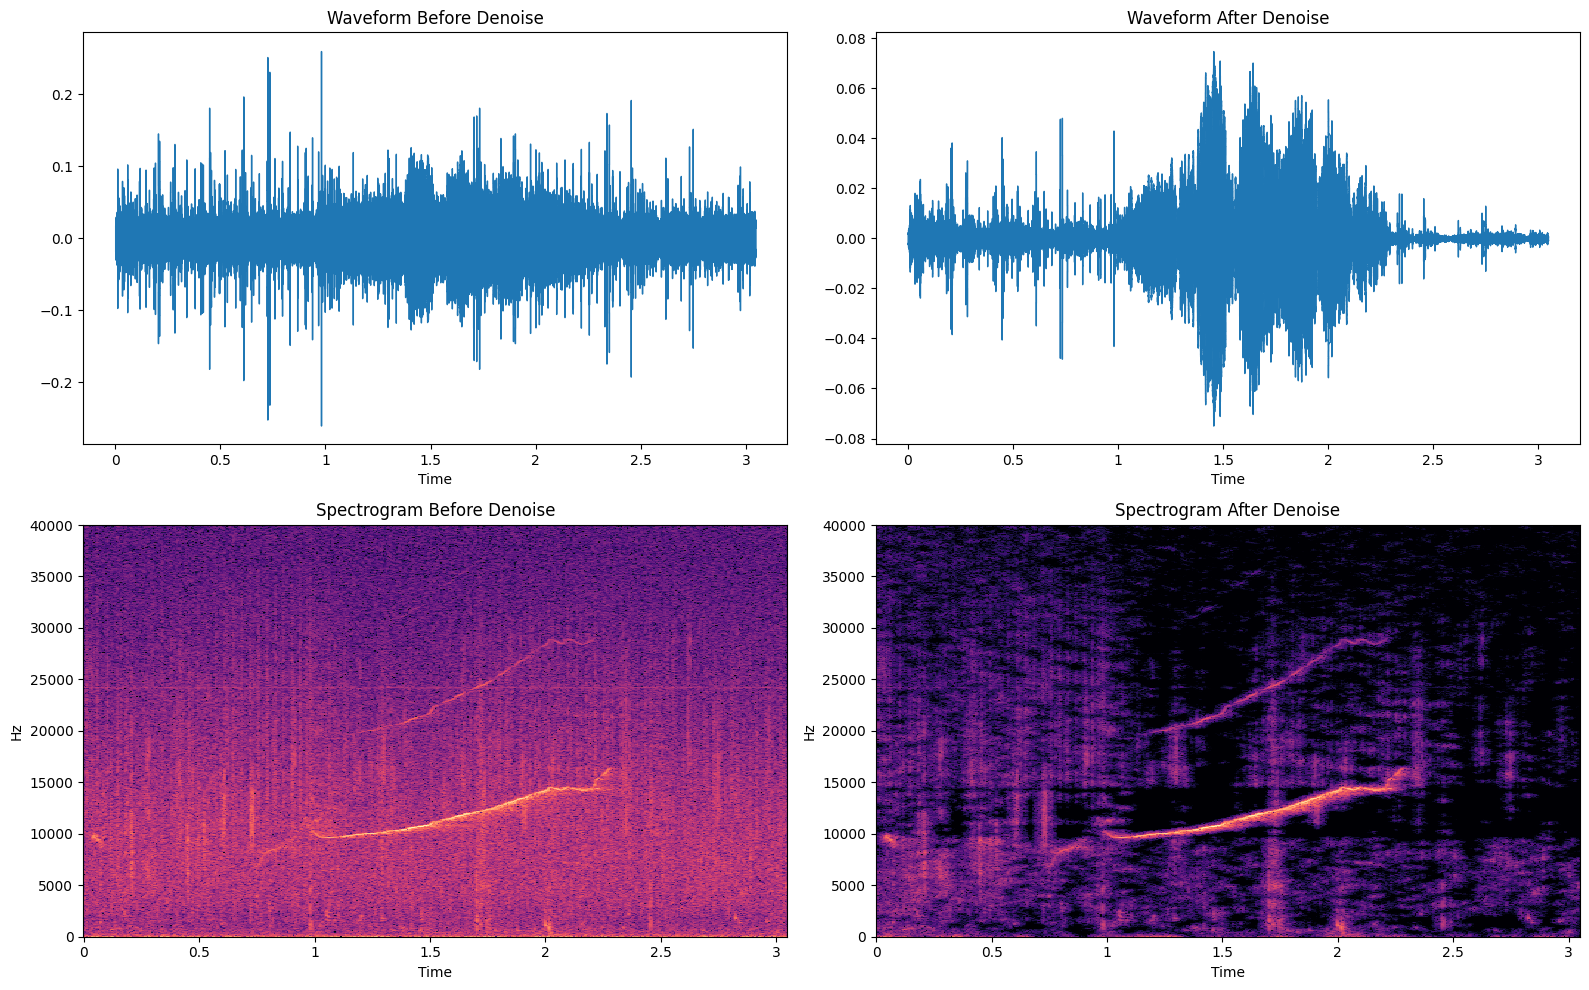

In [9]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr

sample_path = wav_paths[0]  # pilih file pertama, bisa diganti index lain

y_before, sr_before = librosa.load(sample_path, sr=None)

def sr_category(sr):
    if sr < 8000:
        return "no_denoise"
    elif sr < 20000:
        return "low"
    elif sr < 60000:
        return "mid"
    else:
        return "high"

cat = sr_category(sr_before)

if cat == "no_denoise":
    y_after = y_before.copy()
else:
    y_after = nr.reduce_noise(y=y_before.astype(np.float32), sr=sr_before)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
librosa.display.waveshow(y_before, sr=sr_before)
plt.title("Waveform Before Denoise")

plt.subplot(2, 2, 2)
librosa.display.waveshow(y_after, sr=sr_before)
plt.title("Waveform After Denoise")

plt.subplot(2, 2, 3)
D_before = librosa.amplitude_to_db(np.abs(librosa.stft(y_before)), ref=np.max)
librosa.display.specshow(D_before, sr=sr_before, x_axis='time', y_axis='hz', cmap='magma')
plt.title("Spectrogram Before Denoise")

plt.subplot(2, 2, 4)
D_after = librosa.amplitude_to_db(np.abs(librosa.stft(y_after)), ref=np.max)
librosa.display.specshow(D_after, sr=sr_before, x_axis='time', y_axis='hz', cmap='magma')
plt.title("Spectrogram After Denoise")

plt.tight_layout()
plt.show()


<h2>Cutting and Padding</h2>

In [11]:
from torch.nn.functional import pad
def cutter1D(X, cut_point):
    cut_list = []
    cut_point = int(cut_point)

    for x in X:
        x = x.flatten()                 
        n_len = x.shape[0]              
        add_pts = cut_point - n_len

        if n_len <= cut_point:
            pp_left = add_pts // 2
            pp_right = add_pts - pp_left
            x_pad = pad(x, (pp_left, pp_right))
            cut_list.append(x_pad.unsqueeze(0))
        else:
            center = n_len // 2
            half = cut_point // 2
            start = center - half
            end = start + cut_point
            x_crop = x[start:end]
            cut_list.append(x_crop.unsqueeze(0))

    return torch.cat(cut_list, dim=0)

def standardize(X):
    st = torch.std(X, dim=1, keepdim=True)
    mn = torch.mean(X, dim=1, keepdim=True)
    return (X - mn) / (st + 1e-9)


signals = [
    torch.from_numpy(audio_store["/".join(a.split("/")[-2:])]['signal']).float()
    for a in audio_df['index']
]
lengths = [s.shape[0] for s in signals]
cut_point = int(np.median(lengths))

X_cut = cutter1D(signals, cut_point)
X_std = standardize(X_cut)

<h2>Mel-Spectogram Extraction Feature</h2>

In [12]:
# Mel
fe_batch_size = 500
N_batch =  int(X_std.shape[0]/fe_batch_size)+1
spectr = MelSpectrogram(normalized= True, n_mels = 64).to(device)
mx = []
for n in range(N_batch):
    x = X_std[n*fe_batch_size:(n+1)*fe_batch_size].to(device)
    MX_tmp = spectr(x)
    mx.append(MX_tmp)
MX = torch.concat(mx)
MX = MX.unsqueeze(1)

<h2>STFT Power Spectogram</h2>

In [13]:
specr_stft = torchaudio.transforms.Spectrogram(n_fft=1024, hop_length=256, power=2.0).to(device)
sp = []
for n in range(N_batch):
    x = X_std[n*fe_batch_size:(n+1)*fe_batch_size].to(device)
    SP_tmp = specr_stft(x)                    
    SP_tmp = 10.0 * torch.log10(SP_tmp + 1e-8)  
    sp.append(SP_tmp)
SP = torch.concat(sp)     
SP = SP.unsqueeze(1)      


<h2>Wavelet Scattering Transform</h2>

In [14]:
JQ = [(7, 10), (6, 16), (8,14)]
J, Q = JQ[2]
T = X_std.shape[1]

scattering=Scattering1D(J,T,Q)
scattering.cuda()
wst = []
for n in range(N_batch):
    x = X_std[n*fe_batch_size:(n+1)*fe_batch_size].to(device)
    SX_tmp = scattering(x)
    wst.append(SX_tmp)
SX = torch.concat(wst)

<h2>Spectral Contrast Extraction Feature</h2>

In [96]:
N = X_std.shape[0]
N_batch = math.ceil(N / fe_batch_size)

n_fft = 1024
hop_length = 256
n_mels = 64
T_frames = MX.shape[2]

contrast_ch = []

for n in range(N_batch):
    x = X_std[n * fe_batch_size:(n + 1) * fe_batch_size]

    if x.shape[0] == 0:
        continue

    for i in range(x.shape[0]):

        wav = x[i].detach().cpu().numpy().astype(np.float32)
        if wav.ndim == 2 and wav.shape[0] == 1:
            wav = wav.squeeze(0)

        if len(wav) < n_fft:
            wav = np.pad(wav, (0, n_fft - len(wav)),mode='constant')
            
        S = np.abs(librosa.stft(wav, n_fft=n_fft, hop_length=hop_length))
        contrast = librosa.feature.spectral_contrast(
            S=S,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_bands=4
        )
        
        freq_zoom = float(n_mels) / max(1, contrast.shape[0])
        time_zoom = float(T_frames) / max(1, contrast.shape[1])

        contrast_resized = ndi.zoom(contrast, (freq_zoom, time_zoom), order=1)

        if contrast_resized.shape[1] != T_frames:
            contrast_resized = np.pad(
                contrast_resized,
                ((0, 0), (0, max(0, T_frames - contrast_resized.shape[1]))),
                mode='constant'
            )[:, :T_frames]

        if contrast_resized.shape[0] != n_mels:
            contrast_resized = np.pad(
                contrast_resized,
                ((0, max(0, n_mels - contrast_resized.shape[0])), (0, 0)),
                mode='constant'
            )[:n_mels, :]

        contrast_ch.append(torch.tensor(contrast_resized).float())

CNTR = torch.cat(contrast_ch, dim=0)        
CNTR = CNTR.unsqueeze(1)                    
CNTR = CNTR.unsqueeze(1)                    
CNTR = CNTR.to(device)


<h2>Representasi Fitur </h2>

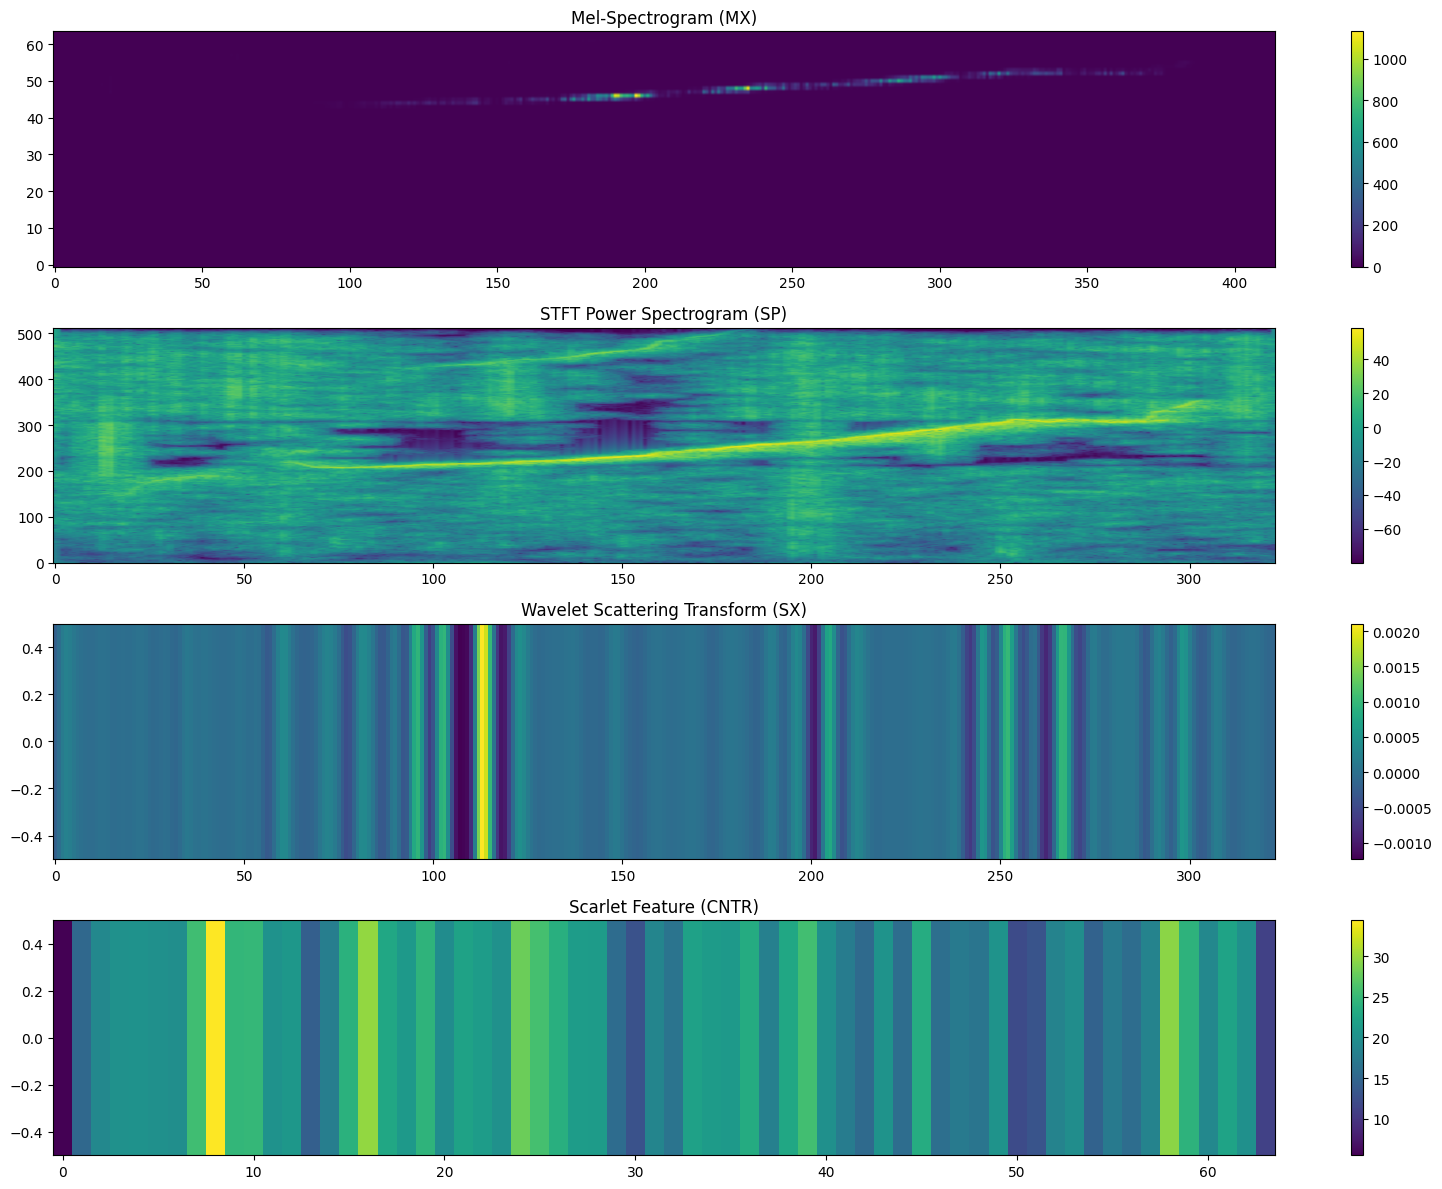

In [16]:
import matplotlib.pyplot as plt
import torch

idx = 0  

mx_i = MX[idx].squeeze().cpu()
sp_i = SP[idx].squeeze().cpu()
sx_i = SX[idx].cpu()
if sx_i.ndim > 1:
    sx_i = sx_i[0]
cntr_i = CNTR[idx].squeeze().cpu()   

if cntr_i.ndim == 1:
    cntr_i = cntr_i.unsqueeze(0)   # → (1, T)


plt.figure(figsize=(16, 12))

# MEL
plt.subplot(4, 1, 1)
plt.imshow(mx_i, aspect='auto', origin='lower')
plt.title("Mel-Spectrogram (MX)")
plt.colorbar()

# STFT
plt.subplot(4, 1, 2)
plt.imshow(sp_i, aspect='auto', origin='lower')
plt.title("STFT Power Spectrogram (SP)")
plt.colorbar()

# WST
plt.subplot(4, 1, 3)
plt.imshow(sx_i.unsqueeze(0), aspect='auto', origin='lower')
plt.title("Wavelet Scattering Transform (SX)")
plt.colorbar()

# SCARLET (Spectral Contrast)
plt.subplot(4, 1, 4)
plt.imshow(cntr_i, aspect='auto', origin='lower')
plt.title("Scarlet Feature (CNTR)")
plt.colorbar()

plt.tight_layout()
plt.show()


In [17]:
meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)

def median_norm(X):
    md = torch.median(X)
    sn = torch.std(X)
    return (X - md) / sn

SX_med = SX
for i in range(SX.shape[0]):
    SX_med[i][order0] = median_norm(SX[i][order0])
    SX_med[i][order1] = median_norm(SX[i][order1])
    SX_med[i][order2] = median_norm(SX[i][order2])

In [18]:
y_arr = np.array([
    audio_store[
        os.path.join(os.path.basename(os.path.dirname(a)), os.path.basename(a))
    ][LABEL]
    for a in audio_df['index'].tolist()
])

labels_sorted = sorted(list(set(y_arr)))
label2id = {l: i for i, l in enumerate(labels_sorted)}

y_encoded = np.array([label2id[l] for l in y_arr])
idx_train, idx_test = train_test_split(
    np.arange(len(y_encoded)),  # indeks semua data
    test_size=0.2,
    random_state=42,            # untuk reproduksibilitas
    shuffle=True
)

y_trXX   = torch.from_numpy(y_encoded[idx_train]).long()
y_testXX = torch.from_numpy(y_encoded[idx_test]).long()


In [97]:
batch_size = 64

train_dataset_mel = TensorDataset(MX.cpu()[idx_train], y_trXX)
val_dataset_mel = TensorDataset(MX.cpu()[idx_test], y_testXX)
train_dataloader_mel = DataLoader(train_dataset_mel, batch_size=batch_size, shuffle=True)
val_dataloader_mel = DataLoader(val_dataset_mel, batch_size=batch_size, shuffle=False)

train_dataset_sp = TensorDataset(SP.cpu()[idx_train], y_trXX)
val_dataset_sp = TensorDataset(SP.cpu()[idx_test], y_testXX)
train_dataloader_sp = DataLoader(train_dataset_sp, batch_size=batch_size, shuffle=True)
val_dataloader_sp = DataLoader(val_dataset_sp, batch_size=batch_size, shuffle=False)

train_dataset_cntr = TensorDataset(CNTR.cpu()[idx_train], y_trXX)
val_dataset_cntr = TensorDataset(CNTR.cpu()[idx_test], y_testXX)
train_dataloader_cntr = DataLoader(train_dataset_cntr, batch_size=batch_size, shuffle=True)
val_dataloader_cntr = DataLoader(val_dataset_cntr, batch_size=batch_size, shuffle=False)

train_dataset_0 = TensorDataset(SX_med[idx_train][:, order0].cpu(), y_trXX)
val_dataset_0 = TensorDataset(SX_med[idx_test][:, order0].cpu(), y_testXX)
train_dataloader_0 = DataLoader(train_dataset_0, batch_size=batch_size, shuffle=True)
val_dataloader_0 = DataLoader(val_dataset_0, batch_size=batch_size, shuffle=False)

train_dataset_1 = TensorDataset(SX_med[idx_train][:, order1].cpu(), y_trXX)
val_dataset_1 = TensorDataset(SX_med[idx_test][:, order1].cpu(), y_testXX)
train_dataloader_1 = DataLoader(train_dataset_1, batch_size=batch_size, shuffle=True)
val_dataloader_1 = DataLoader(val_dataset_1, batch_size=batch_size, shuffle=False)

train_dataset_2 = TensorDataset(SX_med[idx_train][:, order2].cpu(), y_trXX)
val_dataset_2 = TensorDataset(SX_med[idx_test][:, order2].cpu(), y_testXX)
train_dataloader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True)
val_dataloader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False)


## WhaleNet

In [98]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class WhaleNet(nn.Module):
    def __init__(self, block, layers, in_channels=1, num_classes=10):
        super(WhaleNet, self).__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self.make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 64, layers[2], stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [99]:
def training_model(model, train_dataloader, val_dataloader, optimizer,
                   max_lr, num_epochs, fname, y_train,
                   label2id, id2label):

    # --- compute class weight ---
    y_train_np = y_train.numpy()
    classes = np.unique(y_train_np)
    class_weights_np = compute_class_weight(
        class_weight='balanced', classes=classes, y=y_train_np
    )
    class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # scheduler
    steps_per_epoch = len(train_dataloader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=max_lr,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        pct_start=0.1, anneal_strategy='cos',
        div_factor=25.0, final_div_factor=1e4
    )

    best_f1 = -1.0
    best_state = None

    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'val_f1': [], 'train_f1': [], 'lrs': []
    }

    # -----------------------------
    #            TRAINING
    # -----------------------------
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        all_train_preds = []
        all_train_labels = []

        for x, labels in train_dataloader:
            # --- FIX: pastikan input 4D [B, C, H, W] ---
            if x.ndim == 3:  # [B, H, W] → add channel
                x = x.unsqueeze(1)
            elif x.ndim == 4 and x.shape[1] not in [1, 3]:  # swap dim jika salah
                x = x.permute(0, 3, 1, 2)

            x = x.to(device)
            labels = labels.to(device, dtype=torch.long)

            outputs = model(x)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(labels.cpu().numpy())

        train_loss = running_loss / running_total
        train_acc = 100.0 * running_correct / running_total

        # -----------------------------
        #           VALIDATION
        # -----------------------------
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for x_val, labels_val in val_dataloader:
                # --- FIX: pastikan input 4D [B, C, H, W] ---
                if x_val.ndim == 3:
                    x_val = x_val.unsqueeze(1)
                elif x_val.ndim == 4 and x_val.shape[1] not in [1, 3]:
                    x_val = x_val.permute(0, 3, 1, 2)

                x_val = x_val.to(device)
                labels_val = labels_val.to(device, dtype=torch.long)

                outputs_val = model(x_val)
                loss_val = criterion(outputs_val, labels_val)

                val_loss += loss_val.item() * labels_val.size(0)
                preds_val = outputs_val.argmax(dim=1)

                val_correct += (preds_val == labels_val).sum().item()
                val_total += labels_val.size(0)

                all_preds.append(preds_val.cpu().numpy())
                all_labels.append(labels_val.cpu().numpy())

        val_loss = val_loss / val_total
        val_acc = 100.0 * val_correct / val_total

        y_true = np.concatenate(all_labels)
        y_pred = np.concatenate(all_preds)

        # train F1
        y_true_train = np.concatenate(all_train_labels)
        y_pred_train = np.concatenate(all_train_preds)

        val_f1 = f1_score(y_true, y_pred, average='macro',
                          labels=classes, zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro',
                            labels=classes, zero_division=0)

        # save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['lrs'].append(scheduler.get_last_lr())

        print(f"[{fname}] Epoch {epoch+1}/{num_epochs} — "
              f"train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}, "
              f"val_acc: {val_acc:.2f}%, val_f1: {val_f1:.4f}, "
              f"lr: {scheduler.get_last_lr()[0]:.2e}")

        # save best weight
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save(best_state, f"{fname}_best.pth")

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)

    print(f"Best Macro f1 : {best_f1}")

    return model, history, best_f1


In [100]:
def plot_history(history, fname=None):
    # plot loss
    plt.figure()
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss per epoch')
    plt.legend()
    plt.grid(True)
    if fname:
        plt.savefig(f"{fname}_loss.png", bbox_inches='tight')
    plt.show()

    # plot f1
    if 'train_f1' not in history:
        print("Warning: history tidak berisi 'train_f1'. Pastikan menghitung train_f1 tiap epoch.")
    plt.figure()
    plt.plot(history.get('train_f1', []), label='train_f1')
    plt.plot(history.get('val_f1', []), label='val_f1')
    plt.xlabel('epoch')
    plt.ylabel('macro F1')
    plt.title('Macro-F1 per epoch')
    plt.legend()
    plt.grid(True)
    if fname:
        plt.savefig(f"{fname}_f1.png", bbox_inches='tight')
    plt.show()

In [118]:
# LAbelan
labels_sorted = sorted(list(set(y_arr)))
label2id = {l: i for i, l in enumerate(labels_sorted)}
id2label = {v: k for k, v in label2id.items()}


In [108]:
whale_mel = WhaleNet(BasicBlock, [2, 2, 2], in_channels=1, num_classes=32).to(device)
whale_sp = WhaleNet(BasicBlock, [2, 2, 2], in_channels=1, num_classes=32).to(device)
whale_wst_0=WhaleNet(BasicBlock, [2, 2, 2], in_channels=1, num_classes=32).to(device)
whale_wst_1=WhaleNet(BasicBlock, [2, 2, 2], in_channels=1, num_classes=32).to(device)
whale_wst_2=WhaleNet(BasicBlock, [2, 2, 2], in_channels=1, num_classes=32).to(device)
whale_cntr = WhaleNet(BasicBlock, [2, 2, 2], in_channels=1, num_classes=32).to(device)
learning_rate_cntr = .01
optimizer_cntr = torch.optim.AdamW(whale_cntr.parameters(), lr=learning_rate_cntr, amsgrad=True, weight_decay=.001)

learning_rate_mel = .01
optimizer_mel = torch.optim.AdamW(whale_mel.parameters(), lr=learning_rate_mel,amsgrad= True, weight_decay= .001 )

learning_rate_sp = .01
optimizer_sp = torch.optim.AdamW(whale_sp.parameters(), lr=learning_rate_sp, amsgrad=True, weight_decay=.001)

learning_rate_0 = .01
optimizer_0 = torch.optim.AdamW(whale_wst_0.parameters(), lr=learning_rate_0,amsgrad= True, weight_decay= .001 )

learning_rate_1 = .01
optimizer_1 = torch.optim.AdamW(whale_wst_1.parameters(), lr=learning_rate_1,amsgrad= True, weight_decay= .001 )

learning_rate_2 = .01
optimizer_2 = torch.optim.AdamW(whale_wst_2.parameters(), lr=learning_rate_2,amsgrad= True, weight_decay= .001 )

[whalecntr] Epoch 1/100 — train_loss: 0.1523, val_loss: 0.2013, val_acc: 94.49%, val_f1: 0.8787, lr: 6.38e-04
[whalecntr] Epoch 2/100 — train_loss: 0.0688, val_loss: 0.1570, val_acc: 95.59%, val_f1: 0.8893, lr: 1.33e-03
[whalecntr] Epoch 3/100 — train_loss: 0.0384, val_loss: 0.1061, val_acc: 96.32%, val_f1: 0.8948, lr: 2.40e-03
[whalecntr] Epoch 4/100 — train_loss: 0.0237, val_loss: 0.0892, val_acc: 96.69%, val_f1: 0.9284, lr: 3.75e-03
[whalecntr] Epoch 5/100 — train_loss: 0.0263, val_loss: 0.1581, val_acc: 95.59%, val_f1: 0.8874, lr: 5.24e-03
[whalecntr] Epoch 6/100 — train_loss: 0.0705, val_loss: 0.5017, val_acc: 83.46%, val_f1: 0.7705, lr: 6.73e-03
[whalecntr] Epoch 7/100 — train_loss: 0.1409, val_loss: 0.5495, val_acc: 82.35%, val_f1: 0.7885, lr: 8.07e-03
[whalecntr] Epoch 8/100 — train_loss: 0.8282, val_loss: 10.5286, val_acc: 17.65%, val_f1: 0.1810, lr: 9.12e-03
[whalecntr] Epoch 9/100 — train_loss: 0.7791, val_loss: 6.2957, val_acc: 34.56%, val_f1: 0.2732, lr: 9.79e-03
[whalecnt

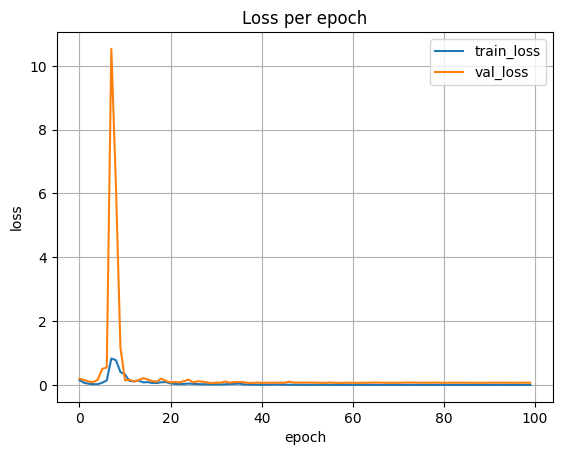

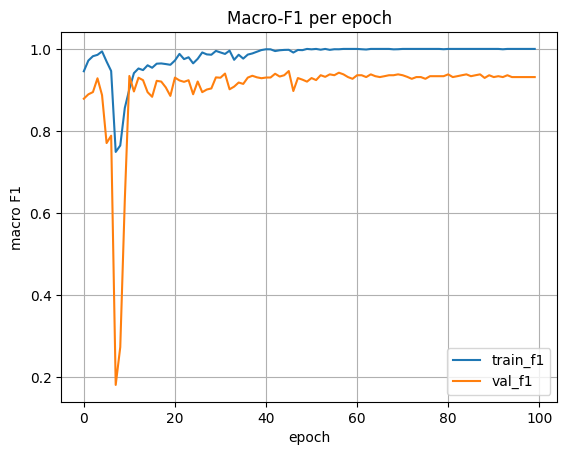

In [113]:
num_epochs = 100 
whale_cntr, hist_cntr, best_f1_cntr = training_model(whale_cntr, train_dataloader_cntr, val_dataloader_cntr,
                                                  optimizer_cntr, learning_rate_cntr, num_epochs,
                                                  'whalecntr',  y_trXX,label2id,id2label)
plot_history(hist_cntr)

In [114]:
import torch
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

def get_whale_probs(model, dataloader):
    """
    Ambil probabilitas dari WhaleNet (1-channel input) pada dataloader.
    """
    model.eval()
    probs_list = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            if x.dim() == 3:
                x = x.unsqueeze(1)  # tambahkan channel
            if x.shape[1] != 1:
                x = x[:, :1, :, :]  # ambil channel pertama saja

            # Resize jika perlu (sesuaikan model)
            if x.shape[2] != 64 or x.shape[3] != 64:  # ganti sesuai input WhaleNet
                x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)

            probs = F.softmax(model(x), dim=1)
            probs_list.append(probs.cpu().numpy())
    return np.concatenate(probs_list, axis=0)

# Contoh pemakaian:
probs_whale = get_whale_probs(whale_cntr, val_dataloader_cntr)
print("Shape probs WhaleNet:", probs_whale.shape)


Shape probs WhaleNet: (272, 32)


[whale_mel] Epoch 1/100 — train_loss: 3.4003, val_loss: 3.3905, val_acc: 6.25%, val_f1: 0.0167, lr: 6.38e-04
[whale_mel] Epoch 2/100 — train_loss: 3.1793, val_loss: 3.6335, val_acc: 4.41%, val_f1: 0.0029, lr: 1.33e-03
[whale_mel] Epoch 3/100 — train_loss: 2.8541, val_loss: 8.6654, val_acc: 4.78%, val_f1: 0.0066, lr: 2.40e-03
[whale_mel] Epoch 4/100 — train_loss: 2.6085, val_loss: 3.8809, val_acc: 9.93%, val_f1: 0.0644, lr: 3.75e-03
[whale_mel] Epoch 5/100 — train_loss: 2.4588, val_loss: 3.5891, val_acc: 9.19%, val_f1: 0.0277, lr: 5.24e-03
[whale_mel] Epoch 6/100 — train_loss: 2.2124, val_loss: 7.6806, val_acc: 2.21%, val_f1: 0.0014, lr: 6.73e-03
[whale_mel] Epoch 7/100 — train_loss: 2.2004, val_loss: 13.6221, val_acc: 4.41%, val_f1: 0.0028, lr: 8.07e-03
[whale_mel] Epoch 8/100 — train_loss: 2.1206, val_loss: 2.5378, val_acc: 21.69%, val_f1: 0.1727, lr: 9.12e-03
[whale_mel] Epoch 9/100 — train_loss: 1.9901, val_loss: 2.7005, val_acc: 20.59%, val_f1: 0.1700, lr: 9.79e-03
[whale_mel] Epoc

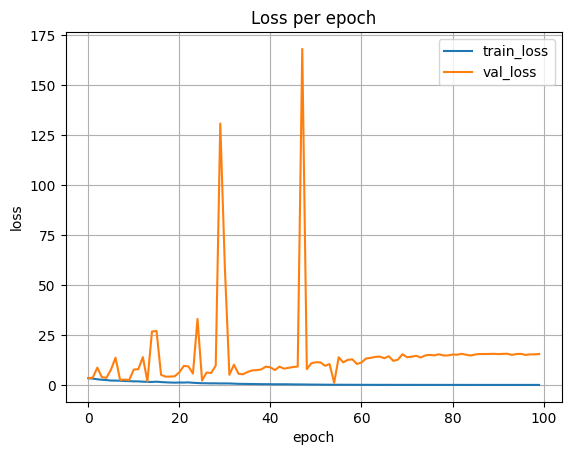

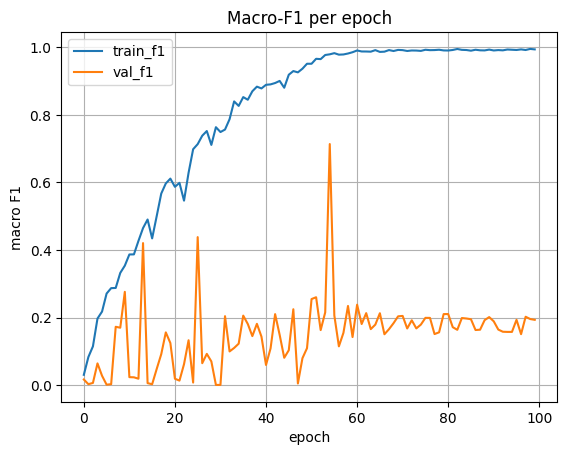

In [34]:
whale_mel, hist_mel_whale, best_f1_mel_whale = training_model(whale_mel, train_dataloader_mel, val_dataloader_mel,
                                                  optimizer_mel, learning_rate_mel, num_epochs,
                                                  'whale_mel',  y_trXX,label2id,id2label)
plot_history(hist_mel_whale)

In [ ]:
whale_sp, hist_sp_whale, best_f1_sp_whale = training_model(whale_sp, train_dataloader_sp, val_dataloader_sp,
                                                  optimizer_sp, learning_rate_sp, num_epochs,
                                                  'whale_sp',y_trXX,label2id,id2label)
plot_history(hist_sp_whale)

[whale_sp] Epoch 1/100 — train_loss: 3.3581, val_loss: 3.2816, val_acc: 5.88%, val_f1: 0.0172, lr: 6.38e-04


In [ ]:
whale_wst_0, hist_w0_whale, best_f1_w0_whale = training_model(whale_wst_0, train_dataloader_0, val_dataloader_0,
                                                   optimizer_0, max_lr=learning_rate_0, num_epochs=num_epochs,
                                                   fname='whale_ws0',  y_train = y_trXX, label_enc = lbe)
plot_history(hist_w0_whale)

In [ ]:
whale_wst_1, hist_w1_whale, best_f1_w1_whale = training_model(whale_wst_1, train_dataloader_1, val_dataloader_1,
                                                   optimizer_1, max_lr=learning_rate_1, num_epochs=num_epochs,
                                                   fname='whale_ws1',  y_train = y_trXX, label_enc = lbe)
plot_history(hist_w1_whale)

In [ ]:
whale_wst_2, hist_w2_whale, best_f1_w2_whale = training_model(whale_wst_2, train_dataloader_2, val_dataloader_2,
                                                   optimizer_2, max_lr=learning_rate_2, num_epochs=num_epochs,
                                                   fname='whale_ws2',  y_train = y_trXX, label_enc = lbe)
plot_history(hist_w2_whale)

## Stratified 

In [26]:
def stratified_kfold_train(CNTR, y, model_fn, optimizer_fn, max_lr, k=5,
                            batch_size=64, num_workers=4, num_epochs = 100, seed=1337, fname_prefix='modelmel'):

    rng = np.random.default_rng(seed)
    le = LabelEncoder().fit(y)
    y_enc = le.transform(y)
    N = len(y_enc)

    class_to_parts = {}
    classes = np.unique(y_enc)
    for cls in classes:
        idxs = np.where(y_enc == cls)[0]
        perm = rng.permutation(idxs)
        parts = np.array_split(perm, k)
        class_to_parts[int(cls)] = parts

    fold_results = []
    fold_indices = []
    CNTR_cpu = CNTR.cpu()

    for fold in range(k):
        # collect val indices as the fold-th part of each class
        val_idx_list = [class_to_parts[int(cls)][fold] for cls in classes]
        val_idx = np.concatenate(val_idx_list).astype(int) if len(val_idx_list) > 0 else np.array([], dtype=int)
        # train idx = all others
        train_idx_list = []
        for cls in classes:
            parts = class_to_parts[int(cls)]
            other = [parts[i] for i in range(k) if i != fold]
            if len(other) > 0:
                train_idx_list.append(np.concatenate(other))
        train_idx = np.concatenate(train_idx_list).astype(int)

        train_idx = rng.permutation(train_idx)
        val_idx = rng.permutation(val_idx)
        fold_indices.append((train_idx, val_idx))

        # build datasets / loaders
        y_train_tensor = torch.as_tensor(y_enc[train_idx])
        y_val_tensor = torch.as_tensor(y_enc[val_idx])

        train_ds = TensorDataset(CNTR_cpu[train_idx], y_train_tensor)
        val_ds = TensorDataset(CNTR_cpu[val_idx], y_val_tensor)

        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
        
        model = model_fn().to(device)
        optimizer = optimizer_fn(model)
        
        print(f"\n=== Fold {fold+1}/{k} | train {len(train_idx)} / val {len(val_idx)} ===")
        model, history, best_f1 = training_resnet(model, train_dl, val_dl, optimizer, max_lr,
                                                  num_epochs, fname=f"{fname_prefix}_fold{fold+1}",
                                                  y_train=y_train_tensor, label_enc=le)
        
        fold_results.append((model, history, best_f1))

    mean_f1 = np.mean([r[2] for r in fold_results])
    print(f"\nMean best macro-F1 across {k} folds: {mean_f1:.4f}")

    return fold_results, le, fold_indices


In [ ]:
def model_fn():
    return WhaleNet(BasicBlock, [2,2,2], in_channels=1, num_classes=len(np.unique(y)))

def optimizer_fn(m):
    return torch.optim.AdamW(m.parameters(), lr=learning_rate_cntr, amsgrad=True, weight_decay=.001)

results, le, fold_idx = stratified_kfold_train(CNTR, y, model_fn, optimizer_fn,
                                              max_lr=learning_rate_cntr, k=5,
                                              batch_size=64, num_epochs=100, seed=1337,
                                              fname_prefix='modelcntr')

## ResNet

In [27]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32).view(1,3,1,1).to(device)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32).view(1,3,1,1).to(device)
def normalize_imagenet(x): return (x - imagenet_mean) / imagenet_std  # expects x in [0,1], shape (B,3,H,W)

In [39]:
from torchvision import models
import torch.nn as nn

def create_resnet50(num_classes=32, in_channels=1, pretrained=True, device=device):
    # load pretrained ResNet50
    model = models.resnet50(pretrained=pretrained)

    # jika input bukan 3-channel, ubah conv1
    if in_channels != 3:
        model.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=model.conv1.out_channels,
            kernel_size=model.conv1.kernel_size,
            stride=model.conv1.stride,
            padding=model.conv1.padding,
            bias=model.conv1.bias is not None
        )
        # init ulang bobot conv1
        nn.init.kaiming_normal_(model.conv1.weight, mode='fan_out', nonlinearity='relu')

    # ubah head sesuai jumlah class
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model.to(device)


In [29]:
def training_resize(model, train_dataloader, val_dataloader, optimizer, max_lr, num_epochs, fname,
                           y_train, label_enc, use_imagenet_norm=True, resize_to_224=True):
    
    y_train_np = y_train.numpy()  
    classes = np.unique(y_train_np)
    class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    steps_per_epoch = len(train_dataloader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr,
                                                    steps_per_epoch=steps_per_epoch, epochs=num_epochs,
                                                    pct_start=0.1, anneal_strategy='cos', div_factor=25.0, final_div_factor=1e4)

    best_f1 = -1.0
    best_state = None
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'train_f1': [], 'val_f1': [], 'lrs': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = running_correct = running_total = 0

        all_train_preds = []
        all_train_labels = []

        for i, (x, labels) in enumerate(train_dataloader):
            x = x.to(device)
            labels = labels.to(device, dtype=torch.long)

            if x.dim() == 3:
                x = x.unsqueeze(1)
            if x.shape[1] == 1:
                x = x.repeat(1,3,1,1)
            if x.shape[2] != 224 or x.shape[3] != 224 :
                x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)

            x = normalize_imagenet(x)
            outputs = model(x)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(labels.cpu().numpy())

        train_loss = running_loss / running_total
        train_acc = 100.0 * running_correct / running_total

        # validation
        model.eval()
        val_loss = val_correct = val_total = 0
        all_preds = []; all_labels = []
        with torch.no_grad():
            for x_val, labels_val in val_dataloader:
                x_val = x_val.to(device)
                labels_val = labels_val.to(device, dtype=torch.long)
                if x_val.dim() == 3:
                    x_val = x_val.unsqueeze(1)
                if x_val.shape[1] == 1:
                    x_val = x_val.repeat(1,3,1,1)
                if resize_to_224 and (x_val.shape[2] != 224 or x_val.shape[3] != 224):
                    x_val = F.interpolate(x_val, size=(224,224), mode='bilinear', align_corners=False)
                if use_imagenet_norm:
                    x_val = normalize_imagenet(x_val)

                outputs_val = model(x_val)
                loss_val = criterion(outputs_val, labels_val)

                val_loss += loss_val.item() * labels_val.size(0)
                preds_val = outputs_val.argmax(dim=1)
                val_correct += (preds_val == labels_val).sum().item()
                val_total += labels_val.size(0)

                all_preds.append(preds_val.cpu().numpy())
                all_labels.append(labels_val.cpu().numpy())

        val_loss = val_loss / val_total
        val_acc = 100.0 * val_correct / val_total
        
        y_true = np.concatenate(all_labels)
        y_pred = np.concatenate(all_preds)
        classes = np.unique(np.concatenate([y_true, y_pred]))

        y_true_train = np.concatenate(all_train_labels)
        y_pred_train = np.concatenate(all_train_preds)
        
        val_f1 = f1_score(y_true, y_pred, average='macro', labels=classes, zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro', labels=classes, zero_division=0)

        history['train_loss'].append(train_loss); history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc); history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1); history['lrs'].append(scheduler.get_last_lr())
        history['train_f1'].append(train_f1)
        
        print(f"[{fname}] Epoch {epoch+1}/{num_epochs} — train_loss: {train_loss:.4f}, "
                  f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}%, val_f1: {val_f1:.4f}, lr: {scheduler.get_last_lr()[0]:.2e}")

        # save best by macro-F1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            torch.save(best_state, f"{fname}_best.pth")

    # restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    y_true_best = []
    y_pred_best = []
    with torch.no_grad():
        for x_val, labels_val in val_dataloader:
            x_val = x_val.to(device)
            labels_val = labels_val.to(device, dtype=torch.long)
            if x_val.dim() == 3:
                x_val = x_val.unsqueeze(1)
            if x_val.shape[1] == 1:
                x_val = x_val.repeat(1,3,1,1)
            if resize_to_224 and (x_val.shape[2] != 224 or x_val.shape[3] != 224):
                x_val = F.interpolate(x_val, size=(224,224), mode='bilinear', align_corners=False)
            if use_imagenet_norm:
                x_val = normalize_imagenet(x_val)
                    
            outputs_val = model(x_val)
            preds_val = outputs_val.argmax(dim=1)
            y_true_best.append(labels_val.cpu().numpy())     # labels_val masih di CPU karena tidak di-.to() di sini
            y_pred_best.append(preds_val.cpu().numpy())

    y_true_best = np.concatenate(y_true_best)
    y_pred_best = np.concatenate(y_pred_best)

    # hitung ulang f1 untuk model terbaik (recomputed)
    recomputed_best_f1 = f1_score(y_true_best, y_pred_best, average='macro', labels=classes, zero_division=0)
    print(f"Recomputed Best Macro F1 on val set (best weights): {recomputed_best_f1:.6f}")

    label_names = label_enc.inverse_transform(classes)   
    print(classification_report(y_true_best, y_pred_best, labels=classes, target_names=label_names, digits=4, zero_division=0))

    
    return model, history, best_f1

In [116]:
warmup_epochs = 5          # phase 1: train head only
finetune_epochs = 25       # phase 2: unfreeze and finetune whole net
batch_size = 32
# learning rates: head warmup uses larger lr; backbone finetune uses much smaller lr
lr_head_warmup = 1e-3
lr_backbone = 1e-5
lr_head_ft = 1e-4          # when finetuning together, keep head lr a bit larger than backbone
weight_decay = 1e-6

def two_phase_train(model, train_loader, val_loader, fname, y_train, label_enc):

    if hasattr(model, "fc"):
        head_module = model.fc
        head_name = "fc"
    elif hasattr(model, "classifier"):
        head_module = model.classifier
        head_name = "classifier"
    else:
        raise ValueError("Model tidak punya atribut 'fc' atau 'classifier'. Tambahkan handler untuk arsitektur ini.")
    
    # --- phase 1: warmup head (freeze backbone) ---
    for n,p in model.named_parameters():
        p.requires_grad = False
        
    for p in head_module.parameters():
        p.requires_grad = True

    optimizer_head = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                      lr=lr_head_warmup, weight_decay=weight_decay)
    
    model, hist1, best1 = training_resize(model, train_loader, val_loader,
                                                optimizer_head, max_lr=lr_head_warmup, y_train=y_train, label_enc=label_enc,
                                                num_epochs=warmup_epochs, fname=f"{fname}_warmup")
    
    # --- phase 2: unfreeze and fine-tune (param groups) ---
    for p in model.parameters(): p.requires_grad = True
    # parameter groups: smaller lr for backbone, larger for head
    head_params = list(head_module.parameters())
    backbone_params = [p for n, p in model.named_parameters() if (head_name not in n)]
    param_groups = [
        {"params": backbone_params, "lr": lr_backbone},
        {"params": head_params,     "lr": lr_head_ft}
    ]
    optimizer_ft = torch.optim.AdamW(param_groups, weight_decay=weight_decay)

    model, hist2, best2 = training_resize(model, train_loader, val_loader,
                                                optimizer_ft, max_lr=lr_head_ft, y_train=y_train, label_enc=label_enc,
                                                num_epochs=finetune_epochs, fname=f"{fname}_finetune")
    

    hist = {}
    for k in hist1.keys():
        hist[k] = hist1[k] + hist2[k]
    best_f1 = max(best1, best2)

    
    return model, hist, best_f1


In [129]:
resnet_mel   = create_resnet50(num_classes=32, in_channels=3, pretrained=True, device=device)
resnet_sp    = create_resnet50(num_classes=32, in_channels=3, pretrained=True, device=device)
resnet_cntr  = create_resnet50(num_classes=32, in_channels=3, pretrained=True, device=device)
resnet_0 = create_resnet50(num_classes=32, in_channels=3, pretrained=True, device=device)
resnet_1 = create_resnet50(num_classes=32, in_channels=3, pretrained=True, device=device)
resnet_2 = create_resnet50(num_classes=32, in_channels=3, pretrained=True, device=device)

In [ ]:
resnet_mel, hist_mel_resnet, best_f1_mel_resnet = two_phase_train(resnet_mel, train_dataloader_mel, val_dataloader_mel, "resnet_mel", y_trXX, lbe)
plot_history(hist_mel_resnet)

[resnet_cntr_warmup] Epoch 1/5 — train_loss: 3.3269, val_loss: 3.1211, val_acc: 15.44%, val_f1: 0.1427, lr: 9.62e-04
[resnet_cntr_warmup] Epoch 2/5 — train_loss: 2.3541, val_loss: 1.9810, val_acc: 60.66%, val_f1: 0.5879, lr: 7.32e-04
[resnet_cntr_warmup] Epoch 3/5 — train_loss: 1.7200, val_loss: 1.5770, val_acc: 75.00%, val_f1: 0.7196, lr: 3.93e-04
[resnet_cntr_warmup] Epoch 4/5 — train_loss: 1.4756, val_loss: 1.4578, val_acc: 76.10%, val_f1: 0.7294, lr: 1.04e-04
[resnet_cntr_warmup] Epoch 5/5 — train_loss: 1.3673, val_loss: 1.4370, val_acc: 80.15%, val_f1: 0.7652, lr: 4.26e-07
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     0.7500    0.4286    0.5455         7
                    Bearded_Seal     1.0000    1.0000    1.0000         4
             Beluga,_White_Whale     1.0000    1.0000    1.0000         9
              Bottlenose_Dolphin     0.7500    1.0000    0.8571         3
                   Bowhead_Whale     1.0000 

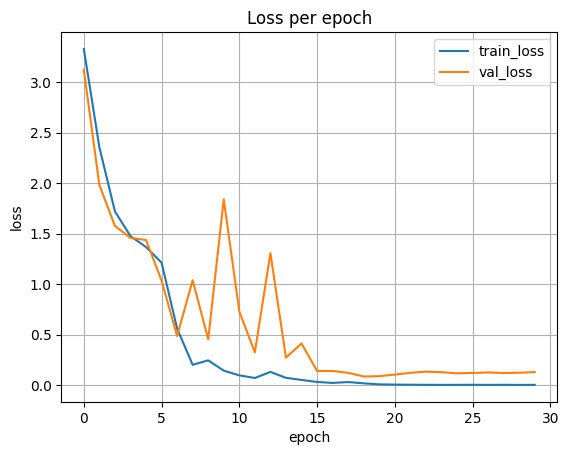

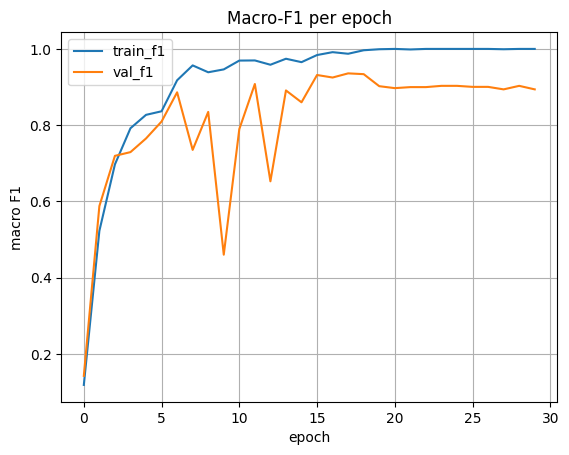

In [130]:
resnet_cntr, hist_cntr_resnet, best_f1_cntr_resnet  = two_phase_train(resnet_cntr, train_dataloader_cntr, val_dataloader_cntr, "resnet_cntr", y_trXX,label2id,id2label )
plot_history(hist_cntr_resnet)

In [131]:
import torch
import torch.nn.functional as F
import numpy as np

def get_resnet_probs(model, dataloader):
    model.eval()
    probs_list = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            # convert 3-channel ke 1-channel jika perlu
            if x.shape[1] == 3 and model.conv1.in_channels == 1:
                x = x.mean(dim=1, keepdim=True)  # grayscale
            
            # pastikan ukuran 224x224
            if x.shape[2] != 224 or x.shape[3] != 224:
                x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)
            
            # normalisasi ImageNet jika model butuh
            x = normalize_imagenet(x)
            
            # ambil probabilitas
            probs = F.softmax(model(x), dim=1)
            probs_list.append(probs.cpu().numpy())
    
    return np.concatenate(probs_list, axis=0)

# ambil probabilitas val set untuk resnet
probs_resnet = get_resnet_probs(resnet_cntr, val_dataloader_cntr)
print("Probs ResNet shape:", probs_resnet.shape)


Probs ResNet shape: (272, 32)


In [ ]:
resnet_sp,  hist_sp_resnet,  best_f1_sp_resnet  = two_phase_train(resnet_sp, train_dataloader_sp, val_dataloader_sp, "resnet_sp", y_trXX, lbe)
plot_history(hist_sp_resnet)

In [ ]:
resnet_0, hist_w0_resnet, best_f1_w0_resnet  = two_phase_train(resnet_0, train_dataloader_0, val_dataloader_0, "resnet_0", y_trXX, lbe)
plot_history(hist_w0_resnet)

In [ ]:
resnet_1, hist_w1_resnet, best_f1_w1_resnet  = two_phase_train(resnet_1, train_dataloader_1, val_dataloader_1, "resnet_1", y_trXX, lbe)
plot_history(hist_w1_resnet)

In [ ]:
resnet_2, hist_w2_resnet, best_f1_w2_resnet  = two_phase_train(resnet_2, train_dataloader_2, val_dataloader_2, "resnet_2", y_trXX, lbe)
plot_history(hist_w2_resnet)

## VGG16

In [78]:
from torchvision import models
import torch.nn as nn

def create_vgg16(num_classes=32, in_channels=1, pretrained=True, device='cuda'):
    model = models.vgg16(pretrained=pretrained)

    # ubah conv1 jika input channel != 3
    if in_channels != 3:
        old_conv = model.features[0]
        model.features[0] = nn.Conv2d(
            in_channels=in_channels,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=old_conv.bias is not None
        )
        # init ulang bobot conv1
        nn.init.kaiming_normal_(model.features[0].weight, mode='fan_out', nonlinearity='relu')

    # ubah classifier terakhir sesuai jumlah class
    if isinstance(model.classifier, nn.Sequential):
        in_f = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_f, num_classes)
    else:
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    return model.to(device)



vgg_mel   = create_vgg16(num_classes=32, in_channels=3, pretrained=True, device=device)
vgg_sp    = create_vgg16(num_classes=32, in_channels=3, pretrained=True, device=device)
vgg_cntr   = create_vgg16(num_classes=32, in_channels=3, pretrained=True, device=device)
vgg_0 = create_vgg16(num_classes=32, in_channels=3, pretrained=True, device=device)
vgg_1 = create_vgg16(num_classes=32, in_channels=3, pretrained=True, device=device)
vgg_2 = create_vgg16(num_classes=32, in_channels=3, pretrained=True, device=device)

In [ ]:
vgg_mel, hist_mel_vgg, best_f1_mel_vgg = two_phase_train(vgg_mel, train_dataloader_mel, val_dataloader_mel, "vgg_mel", y_trXX, lbe)
plot_history(hist_mel_vgg)

In [ ]:
vgg_sp, hist_sp_vgg, best_f1_sp_vgg = two_phase_train(vgg_sp, train_dataloader_sp, val_dataloader_sp, "vgg_sp", y_trXX, lbe)
plot_history(hist_sp_vgg)

In [122]:
def two_phase_train(model, train_loader, val_loader, fname, y_train, label2id, id2label):

    # deteksi head
    if hasattr(model, "fc"):
        head_module = model.fc
        head_name = "fc"
    elif hasattr(model, "classifier"):
        head_module = model.classifier
        head_name = "classifier"
    else:
        raise ValueError("Model tidak punya atribut 'fc' atau 'classifier'. Tambahkan handler untuk arsitektur ini.")
    
    # --- phase 1: warmup head (freeze backbone) ---
    for n, p in model.named_parameters():
        p.requires_grad = False
    for p in head_module.parameters():
        p.requires_grad = True

    optimizer_head = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr_head_warmup, weight_decay=weight_decay
    )
    
    model, hist1, best1 = training_resize(
        model, train_loader, val_loader, optimizer_head,
        max_lr=lr_head_warmup, y_train=y_train,
        label2id=label2id, id2label=id2label,
        num_epochs=warmup_epochs, fname=f"{fname}_warmup"
    )
    
    # --- phase 2: unfreeze and fine-tune (param groups) ---
    for p in model.parameters(): p.requires_grad = True
    head_params = list(head_module.parameters())
    backbone_params = [p for n, p in model.named_parameters() if head_name not in n]
    param_groups = [
        {"params": backbone_params, "lr": lr_backbone},
        {"params": head_params, "lr": lr_head_ft}
    ]
    optimizer_ft = torch.optim.AdamW(param_groups, weight_decay=weight_decay)

    model, hist2, best2 = training_resize(
        model, train_loader, val_loader, optimizer_ft,
        max_lr=lr_head_ft, y_train=y_train,
        label2id=label2id, id2label=id2label,
        num_epochs=finetune_epochs, fname=f"{fname}_finetune"
    )
    
    # gabungkan history
    hist = {k: hist1[k] + hist2[k] for k in hist1.keys()}
    best_f1 = max(best1, best2)

    return model, hist, best_f1


def training_resize(model, train_dataloader, val_dataloader, optimizer, max_lr, num_epochs, fname,
                    y_train, label2id, id2label, use_imagenet_norm=True, resize_to_224=True):

    y_train_np = y_train.numpy()
    classes = np.array(list(label2id.values()))  # gunakan label2id untuk mapping class
    class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_np)
    class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    steps_per_epoch = len(train_dataloader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=max_lr,
        steps_per_epoch=steps_per_epoch, epochs=num_epochs,
        pct_start=0.1, anneal_strategy='cos',
        div_factor=25.0, final_div_factor=1e4
    )

    best_f1 = -1.0
    best_state = None
    history = {k: [] for k in ['train_loss', 'val_loss', 'train_acc', 'val_acc', 'train_f1', 'val_f1', 'lrs']}

    for epoch in range(num_epochs):
        model.train()
        running_loss = running_correct = running_total = 0
        all_train_preds, all_train_labels = [], []

        for x, labels in train_dataloader:
            x = x.to(device)
            labels = labels.to(device, dtype=torch.long)

            if x.dim() == 3:
                x = x.unsqueeze(1)
            if x.shape[1] == 1:
                x = x.repeat(1,3,1,1)
            if resize_to_224 and (x.shape[2] != 224 or x.shape[3] != 224):
                x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)
            if use_imagenet_norm:
                x = normalize_imagenet(x)

            outputs = model(x)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)
            all_train_preds.append(preds.cpu().numpy())
            all_train_labels.append(labels.cpu().numpy())

        train_loss = running_loss / running_total
        train_acc = 100.0 * running_correct / running_total

        # validation
        model.eval()
        val_loss = val_correct = val_total = 0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for x_val, labels_val in val_dataloader:
                x_val = x_val.to(device)
                labels_val = labels_val.to(device, dtype=torch.long)

                if x_val.dim() == 3:
                    x_val = x_val.unsqueeze(1)
                if x_val.shape[1] == 1:
                    x_val = x_val.repeat(1,3,1,1)
                if resize_to_224 and (x_val.shape[2] != 224 or x_val.shape[3] != 224):
                    x_val = F.interpolate(x_val, size=(224,224), mode='bilinear', align_corners=False)
                if use_imagenet_norm:
                    x_val = normalize_imagenet(x_val)

                outputs_val = model(x_val)
                loss_val = criterion(outputs_val, labels_val)

                val_loss += loss_val.item() * labels_val.size(0)
                preds_val = outputs_val.argmax(dim=1)
                val_correct += (preds_val == labels_val).sum().item()
                val_total += labels_val.size(0)
                all_preds.append(preds_val.cpu().numpy())
                all_labels.append(labels_val.cpu().numpy())

        val_loss /= val_total
        val_acc = 100.0 * val_correct / val_total

        y_true = np.concatenate(all_labels)
        y_pred = np.concatenate(all_preds)
        y_true_train = np.concatenate(all_train_labels)
        y_pred_train = np.concatenate(all_train_preds)

        val_f1 = f1_score(y_true, y_pred, average='macro', labels=classes, zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='macro', labels=classes, zero_division=0)

        # save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['lrs'].append(scheduler.get_last_lr())

        print(f"[{fname}] Epoch {epoch+1}/{num_epochs} — train_loss: {train_loss:.4f}, "
              f"val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}%, val_f1: {val_f1:.4f}, lr: {scheduler.get_last_lr()[0]:.2e}")

        # save best
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            torch.save(best_state, f"{fname}_best.pth")

    # restore best
    if best_state is not None:
        model.load_state_dict(best_state)

    # laporan klasifikasi
    label_names = [id2label[i] for i in classes]
    print(classification_report(y_true, y_pred, labels=classes, target_names=label_names, digits=4, zero_division=0))
    print(f"Recomputed Best Macro F1: {best_f1:.6f}")

    return model, history, best_f1


[resnet_cntr_warmup] Epoch 1/5 — train_loss: 0.8563, val_loss: 0.4559, val_acc: 93.38%, val_f1: 0.8982, lr: 9.62e-04
[resnet_cntr_warmup] Epoch 2/5 — train_loss: 1.6137, val_loss: 0.7747, val_acc: 93.01%, val_f1: 0.8907, lr: 7.32e-04
[resnet_cntr_warmup] Epoch 3/5 — train_loss: 2.4115, val_loss: 1.1044, val_acc: 92.65%, val_f1: 0.8945, lr: 3.93e-04
[resnet_cntr_warmup] Epoch 4/5 — train_loss: 0.5816, val_loss: 0.8047, val_acc: 95.96%, val_f1: 0.9214, lr: 1.04e-04
[resnet_cntr_warmup] Epoch 5/5 — train_loss: 0.4785, val_loss: 0.6789, val_acc: 97.06%, val_f1: 0.9310, lr: 4.26e-07
                                  precision    recall  f1-score   support

        Atlantic_Spotted_Dolphin     1.0000    1.0000    1.0000         7
                    Bearded_Seal     1.0000    1.0000    1.0000         4
             Beluga,_White_Whale     1.0000    1.0000    1.0000         9
              Bottlenose_Dolphin     1.0000    1.0000    1.0000         3
                   Bowhead_Whale     1.0000 

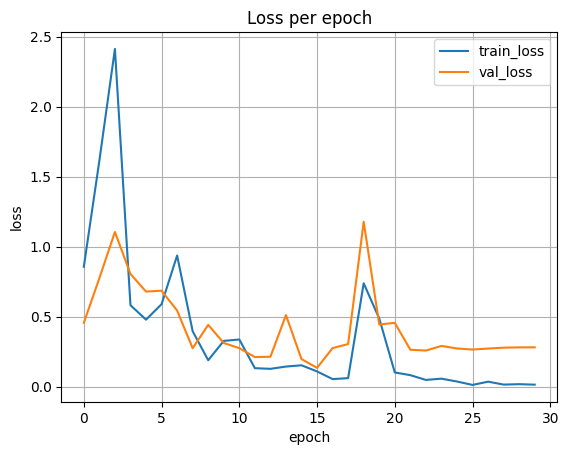

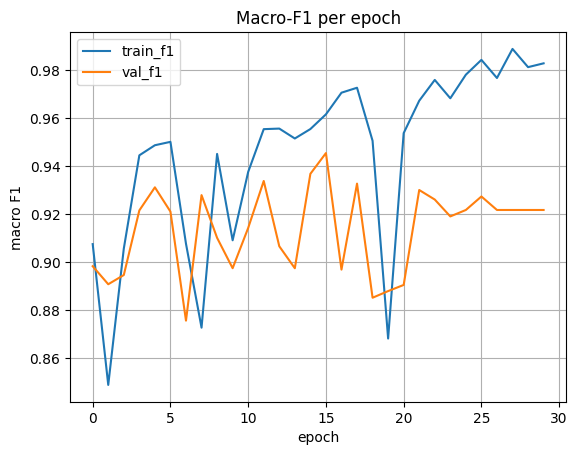

In [126]:
vgg_cntr, hist_cntr_vgg, best_f1_cntr_vgg =two_phase_train(
    vgg_cntr,
    train_dataloader_cntr,
    val_dataloader_cntr,
    fname="resnet_cntr",
    y_train=y_trXX,
    label2id=label2id,
    id2label=id2label
)
plot_history(hist_cntr_vgg)

In [127]:
import torch
import torch.nn.functional as F
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"

def normalize_imagenet(x):
    """
    Normalisasi input untuk pretrained model ImageNet (VGG, ResNet).
    """
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
    return (x - mean) / std

def get_vgg_probs(model, dataloader):
    """
    Ambil probabilitas dari VGGNet (3-channel input).
    """
    model.eval()
    probs_list = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            if x.dim() == 3:
                x = x.unsqueeze(1)
            if x.shape[1] == 1:
                x = x.repeat(1,3,1,1)  # konversi grayscale ke 3-channel
            if x.shape[2] != 224 or x.shape[3] != 224:
                x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)
            x = normalize_imagenet(x)
            probs = F.softmax(model(x), dim=1)
            probs_list.append(probs.cpu().numpy())
    return np.concatenate(probs_list, axis=0)

# Ambil probabilitas VGG
probs_vgg = get_vgg_probs(vgg_cntr, val_dataloader_cntr)
print("Shape probs VGG:", probs_vgg.shape)


Shape probs VGG: (272, 32)


In [80]:
# Simpan model lengkap (struktur + weight)
torch.save(resnet_cntr, "resnet_cntr_full.pth")
torch.save(vgg_cntr, "vgg_cntr_full.pth")

# Simpan hanya state_dict (rekomendasi PyTorch)
torch.save(resnet_cntr.state_dict(), "resnet_cntr_weights.pth")
torch.save(vgg_cntr.state_dict(), "vgg_cntr_weights.pth")


In [ ]:
vgg_0, hist_0_vgg, best_f1_0_vgg = two_phase_train(vgg_0, train_dataloader_0, val_dataloader_0, "vgg_0", y_trXX, lbe)
plot_history(hist_0_vgg)

In [ ]:
vgg_1, hist_1_vgg, best_f1_1_vgg = two_phase_train(vgg_1, train_dataloader_1, val_dataloader_1, "vgg_1", y_trXX, lbe)
plot_history(hist_1_vgg)

In [ ]:
vgg_2, hist_2_vgg, best_f1_2_vgg = two_phase_train(vgg_2, train_dataloader_2, val_dataloader_2, "vgg_2", y_trXX, lbe)
plot_history(hist_2_vgg)

# Inference of ensemble avengers

In [110]:
weight_path = "whalecntr_best (1).pth"
state_dict = torch.load(weight_path, map_location=device)  # map_location agar sesuai device

# Masukkan weight ke model
whale_cntr.load_state_dict(state_dict)

# Set ke mode eval jika untuk inference
whale_cntr.eval()

print("Weights loaded successfully from", weight_path)

Weights loaded successfully from whalecntr_best (1).pth


In [136]:
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# pastikan shape: (num_samples, num_classes)
print(probs_whale.shape, probs_vgg.shape, probs_resnet.shape)

# --------------------------
# Step 1: Soft voting (weighted average)
# --------------------------
w_whale, w_vgg, w_resnet = 0.3, 0.3, 0.4
ensemble_probs = w_whale * probs_whale + w_vgg * probs_vgg + w_resnet * probs_resnet

# --------------------------
# Step 2: ambil label ground truth
# --------------------------
y_true = np.concatenate([labels.cpu().numpy() for _, labels in val_dataloader_cntr], axis=0)
num_classes = ensemble_probs.shape[1]

# --------------------------
# Step 3: cari threshold optimal per kelas menggunakan F1
# --------------------------
best_thresholds = np.zeros(num_classes)
y_pred_optimal = np.zeros_like(y_true)

for c in range(num_classes):
    best_f1 = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.9, 0.01):
        y_pred_c = (ensemble_probs[:,c] >= thresh).astype(int)
        y_true_c = (y_true == c).astype(int)
        f1 = f1_score(y_true_c, y_pred_c)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    best_thresholds[c] = best_thresh

# --------------------------
# Step 4: prediksi final menggunakan threshold optimal
# --------------------------
y_pred_final = np.zeros_like(y_true)
for c in range(num_classes):
    class_idx = (ensemble_probs[:, c] >= best_thresholds[c])
    y_pred_final[class_idx] = c

# --------------------------
# Step 5: evaluasi
# --------------------------
macro_f1 = f1_score(y_true, y_pred_final, average='macro')
print("Optimal thresholds per class:", best_thresholds)
print(f"Soft Voting + Thresholding Macro-F1: {macro_f1:.4f}")
print(classification_report(y_true, y_pred_final, digits=4))

# --------------------------
# Optional: ROC-AUC per kelas
# --------------------------
roc_auc_per_class = [roc_auc_score((y_true==c).astype(int), ensemble_probs[:,c]) for c in range(num_classes)]
print("ROC-AUC per class:", roc_auc_per_class)
print("Mean ROC-AUC:", np.mean(roc_auc_per_class))


(272, 32) (272, 32) (272, 32)
Optimal thresholds per class: [0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.48 0.1  0.31 0.3  0.13 0.32 0.1
 0.1  0.1  0.1  0.68 0.2  0.1  0.1  0.3  0.26 0.15 0.1  0.31 0.1  0.1
 0.1  0.5  0.1  0.4 ]
Soft Voting + Thresholding Macro-F1: 0.9851
              precision    recall  f1-score   support

           0     0.7778    1.0000    0.8750         7
           1     1.0000    1.0000    1.0000         4
           2     1.0000    1.0000    1.0000         9
           3     1.0000    1.0000    1.0000         3
           4     1.0000    1.0000    1.0000         8
           5     1.0000    0.9091    0.9524        11
           6     1.0000    0.9000    0.9474        10
           7     1.0000    1.0000    1.0000         8
           8     1.0000    1.0000    1.0000        12
           9     1.0000    0.9474    0.9730        19
          10     1.0000    1.0000    1.0000         8
          11     1.0000    1.0000    1.0000         3
          12     1.0000    1.00

In [ ]:
print("A")

# Late Fusion

In [ ]:
def get_img_probs(models, dataloader, device):
  probs = {}
  y_ref = None

  for name, model in models.items():
    dl = dataloaders[name]
    model.eval()
    model.to(device)
    probs_list = []
    ys = []

    with torch.no_grad():
      for xb, yb in dl:
        xb = xb.to(device)
        probs = softmax(model(xb)).cpu().numpy()
        probs_list.append(probs)
        ys.append(yb.cpu().numpy())

    probs[name] = np.concatenate(probs_list, axis=0)
    ys = np.concatenate(ys, axis = 0)
    if y_ref is None:
      y_ref = ys
    else :
      assert np.array_equal(y_ref, ys), "Y tidak sama"

  return probs, y_ref

def get_tab_probs(models, X):
  probs = {}
  for name, model in models.items():
      try :
        p = m.predict_proba(X)
      except Exception :
        p = m.predict(X)
      probs[name] = np.asarray(p)

  return probs

In [ ]:
def average_probs(probs_dict):
    keys = list(probs_dict.keys())
    arrs = [probs_dict[k] for k in keys]
    return np.mean(np.stack(arrs, axis=0), axis=0)

In [ ]:
def weighted_two_stage(probs_tab_dict, probs_img_dict, y_true, weights = np.linspace(0,1,21)):
    probs_tab_avg = average_probs(probs_tab_dict)
    probs_img_avg = average_probs(probs_img_dict)

    best_w, best_f1 = None, -1
    best_preds = None
    for w in weights:
        probs = w * probs_img_avg + (1 - w) * probs_tab_avg
        preds = np.argmax(probs, axis=1)
        f1 = f1_score(y_true, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_w = w
            best_preds = preds
    report = classification_report(y_true, best_preds, digits=4)
    return {'best_w': best_w, 'best_f1': best_f1, 'preds': best_preds, 'report': report,
            'probs_img_avg': probs_img_avg, 'probs_tab_avg': probs_tab_avg}

def stacking_logistic(probs_dict_all_train, y_train, probs_dict_all_test, y_test=None):
    keys = list(probs_dict_all_train.keys())
    X_meta_train = np.concatenate([probs_dict_all_train[k] for k in keys], axis=1)
    X_meta_test  = np.concatenate([probs_dict_all_test[k]  for k in keys], axis=1)

    meta = LogisticRegression(max_iter=2000, multi_class='multinomial')
    meta.fit(X_meta_train, y_train)
    probs_meta = meta.predict_proba(X_meta_test)
    preds_meta = np.argmax(probs_meta, axis=1)

    out = {'meta_clf': meta, 'preds': preds_meta, 'probs': probs_meta}
    if y_test is not None:
        out['f1'] = f1_score(y_test, preds_meta, average='macro')
        out['report'] = classification_report(y_test, preds_meta, digits=4)
    return out



## Single Model

In [ ]:
# 1) Tabular models (python objects): rf, lgb, ann
# X_test, y_test
model_name = 'best_ann_model2.h5'
model_rf = RandomForestClassifier(**rfparams, class_weight=class_weight_dict, random_state=42)
model_lgb = LGBMClassifier(**lgbmparams, class_weight=class_weight_dict, random_state=42)
model_ann = tf.keras.models.load_model(model_name)

models_tab = {'rf': model_rf, 'lgb': model_lgb, 'ann': model_ann}
probs_tab_test = get_tabular_probs(models_tab, X_test)

# 2) Image models (PyTorch) & dataloaders aligned
torch_models = {'whale': wst_cntr, 'resnet': resnet_cntr, 'vgg': vgg_cntr}
dataloaders_test = {'whale': val_dataloader_cntr, 'resnet': val_dataloader_cntr, 'vgg': val_dataloader_cntr}
probs_img_test, y_test_img = get_image_probs(torch_models, val_dataloader_cntr, device)

###
result = weighted_two_stage(probs_tab_val, probs_img_val, y_test)
print("Weighted ensemble best_w, f1:", result['best_w'], result['best_f1'])
print(result['report'])

meta_out = stacking_logistic(
    probs_dict_all_train = {**probs_tab_val, **probs_img_val},  # concat all model probs (val -> meta-train)
    y_train = y_train,
    probs_dict_all_test  = {**probs_tab_test, **probs_img_test},
    y_test = y_test
)

print("Stacking F1:", meta_out['f1'])
print(meta_out['report'])

## Multi-Ensembling

In [ ]:
## ens tabular
model_name = 'best_ann_model2.h5'
model_rf = RandomForestClassifier(**rfparams, class_weight=class_weight_dict, random_state=42)
model_lgb = LGBMClassifier(**lgbmparams, class_weight=class_weight_dict, random_state=42)
model_ann = tf.keras.models.load_model(model_name)

model_rf.fit(X_train, y_train)
model_lgb.fit(X_train, y_train)

## train
y_pred_rf_train = model_rf.predict(X_train)
y_pred_lgb_train = model_lgb.predict(X_train)
y_pred_ann_train = np.argmax(model_ann.predict(X_train), axis=1)

y_pred_ensemble_train = []
for i in range(len(y_train)):
    votes = [y_pred_rf_train[i], y_pred_lgb_train[i], y_pred_ann_train[i]]
    final_vote = max(set(votes), key=votes.count)
    y_pred_ensemble_train.append(final_vote)
y_pred_ensemble_train = np.array(y_pred_ensemble_train)

## test
y_pred_rf = model_rf.predict(X_test)
y_pred_lgb = model_lgb.predict(X_test)
y_pred_ann = np.argmax(model_ann.predict(X_test), axis=1)

y_pred_ensemble = []
for i in range(len(y_test)):
    votes = [y_pred_rf[i], y_pred_lgb[i], y_pred_ann[i]]
    final_vote = max(set(votes), key=votes.count)
    y_pred_ensemble.append(final_vote)
y_pred_ensemble = np.array(y_pred_ensemble)


## ens image
y_preds_1 = []
y_preds_2 = []
y_preds_3 = []
# train
y_p1 = []; y_p2 = []; y_p3 = []; lab_train = []
for (x1, labels1), (x3, labels3) in zip(train_dataloader_1, train_dataloader_sp):
    x1 = x1.to(device); x3 = x3.to(device)
    with torch.no_grad():
        p1 = whale_wst_1(x1).argmax(dim=1).cpu().numpy()
        p2 = resnet_wst_1(x1).argmax(dim=1).cpu().numpy()
        p3 = vgg_sp(x3).argmax(dim=1).cpu().numpy()
    y_p1.extend(p1.tolist()); y_p2.extend(p2.tolist()); y_p3.extend(p3.tolist())
    lab_train.extend(labels1.cpu().numpy().tolist())

y_pred_ensemble_img_train = np.array([max(set(v), key=v.count) for v in zip(y_p1, y_p2, y_p3)])

## test
y_pred_ensemble_image = []
for (x1, labels1), (x3, labels3) in zip(val_dataloader_1, val_dataloader_sp):
    x1 = x1.to(device)
    x3 = x3.to(device)
    with torch.no_grad():
        outputs_val_1 = whale_wst_1(x1)
        preds_val_1 = outputs_val_1.argmax(dim=1).cpu().numpy()
        outputs_val_2 = resnet_wst_1(x1)
        preds_val_2 = outputs_val_2.argmax(dim=1).cpu().numpy()

        outputs_val_3 = vgg_sp(x3)
        preds_val_3 = outputs_val_3.argmax(dim=1).cpu().numpy()

    y_preds_1.extend(preds_val_1.tolist())
    y_preds_2.extend(preds_val_2.tolist())
    y_preds_3.extend(preds_val_3.tolist())

    # gunakan labels dari salah satu dataloader
    # labels_img.extend(labels1.cpu().numpy().tolist())

y_pred_ensemble_img = []
for a, b, c in zip(y_preds_1, y_preds_2, y_preds_3):
    votes = [a, b, c]
    final = max(set(votes), key=votes.count)
    y_pred_ensemble_img.append(final)
y_pred_ensemble_img = np.array(y_pred_ensemble_img)
# labels_img = np.array(labels_img)


X_meta_train = np.column_stack([y_pred_ensemble_train, y_pred_ensemble_img_train])
X_meta_test = np.column_stack([y_pred_ensemble, y_pred_ensemble_img])

clf = LogisticRegression(max_iter=1000)
clf.fit(X_meta_train, y_train)

y_pred_meta = clf.predict(X_meta_test)

print("Classification report (meta-model):")
print(classification_report(y_test, y_pred_meta))



## Sample Rate Change

In [ ]:
SR = 80000
audio_store = {}
for i, row in tqdm(train.iterrows(), total=len(train)):
    file_path = os.path.join(TRAIN_AUDIO_PATH, f'{row["audio"]}.wav')
    y, sr = librosa.load(file_path, sr=None)
    y = librosa.resample(y, orig_sr=sr, target_sr=SR)
    audio_store[row['audio']] = {'signal': y, 'sr': SR, 'species': row[LABEL]}

audio_df = pd.DataFrame.from_dict(audio_store, orient='index')
audio_df.reset_index(inplace=True)
audio_df


In [ ]:
def create_features(audio_signal, sampling_rate, n_fft=2048, hop_length=512, n_mfcc=40, n_mels=64):
    features = {}
    # ZCR
    zcr = librosa.feature.zero_crossing_rate(audio_signal, frame_length=n_fft, hop_length=hop_length)
    features['zcr_mean'] = np.mean(zcr)
    features['zcr_std'] = np.std(zcr)

    # chroma
    chroma_stft = librosa.feature.chroma_stft(y=audio_signal, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)
    features['chroma_stft_mean'] = np.mean(chroma_stft)
    features['chroma_stft_std'] = np.std(chroma_stft)

    # tempogram
    tempogram = librosa.feature.tempogram(y=audio_signal, sr=sampling_rate, hop_length=hop_length)
    features['tempogram_mean'] = np.mean(tempogram)
    features['tempogram_std'] = np.std(tempogram)

    # Spectral Centroid
    spec_centroid = librosa.feature.spectral_centroid(y=audio_signal, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)
    features['spec_centroid_mean'] = np.mean(spec_centroid)
    features['spec_centroid_std'] = np.std(spec_centroid)

    # Spectral Rolloff
    spec_rolloff = librosa.feature.spectral_rolloff(y=audio_signal, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)
    features['spec_rolloff_mean'] = np.mean(spec_rolloff)
    features['spec_rolloff_std'] = np.std(spec_rolloff)

    rms_energy = librosa.feature.rms(y=audio_signal, frame_length=n_fft, hop_length=hop_length)
    features['rms_energy_mean'] = np.mean(rms_energy)
    features['rms_energy_std'] = np.std(rms_energy)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio_signal, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)

    stft = np.abs(librosa.stft(audio_signal, n_fft=2048, hop_length=512))
    spectogram = librosa.amplitude_to_db(stft, ref=np.max)
    features['spectogram_mean'] = np.mean(spectogram)
    features['spectogram_std'] = np.std(spectogram)

    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sampling_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    features['mel_spectrogram_mean'] = np.mean(mel_spectrogram)
    features['mel_spectrogram_std'] = np.std(mel_spectrogram)

    # MFCCs
    mfccs = librosa.feature.mfcc(y=audio_signal, sr=sampling_rate, n_mfcc=40, n_fft=n_fft, hop_length=hop_length)
    for i in range(1, 40):
        features[f'mfcc{i}_mean'] = np.mean(mfccs[i-1])
        features[f'mfcc{i}_std'] = np.std(mfccs[i-1])

    return features

In [ ]:
feature_list = []
for idx, row in tqdm(audio_df.iterrows(), total=len(audio_df)):
    sig = row['signal']; sr = row['sr']; lbl = row['species']
    feats = create_features(sig_clean, sr)
    feats['label'] = lbl
    feature_list.append(feats)
f_train = pd.DataFrame(feature_list)

In [ ]:
lbe = LabelEncoder()
f_train['label_enc'] = lbe.fit_transform(f_train['label'])
label_mapping = dict(zip(lbe.classes_, range(len(lbe.classes_))))

scaler = StandardScaler()
X_tab = f_train.drop(columns=['label','label_enc'])
X_tab_scaled = scaler.fit_transform(X_tab)
X_tab = pd.DataFrame(X_tab_scaled, columns=X_tab.columns)
y_tab = f_train['label_enc'].values

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_tab), y=y_tab)
class_weight_dict = {i : class_weights[i] for i in range(len(class_weights))}
# class_weight_dict

def stratified_with_min_test(X, y, test_size=0.2, min_test_per_class=1, random_state=42):
    X = np.array(X)
    y = np.array(y)
    rng = np.random.default_rng(random_state)

    unique_classes, counts = np.unique(y, return_counts=True)
    test_idx = np.zeros(len(y), dtype=bool)

    for cls, count in zip(unique_classes, counts):
        cls_idx = np.where(y == cls)[0]
        if count <= min_test_per_class: # karena weddell_seal cuma punya 2 sampel
            continue
        n_test = max(min_test_per_class, int(np.ceil(test_size * count)))
        test_samples = rng.choice(cls_idx, size=n_test, replace=False)
        test_idx[test_samples] = True

    X_train, X_test = X[~test_idx], X[test_idx]
    y_train, y_test = y[~test_idx], y[test_idx]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = stratified_with_min_test(X_tab, y_tab, test_size=0.2, min_test_per_class=1, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weight_dict, max_iter=1000),
    'Random Forest': RandomForestClassifier(class_weight=class_weight_dict),
    'SVC': SVC(class_weight=class_weight_dict, probability=True),
    'XGBoost': XGBClassifier(use_label_encoder=False, random_state=42, scale_pos_weight=class_weight_dict),
    'LightGBM': LGBMClassifier(class_weight=class_weight_dict, verbose=-1),
}

for model_name, model in models.items():
    print(f'Name: {model_name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()
    print("="*60)